In [1]:
from google.colab import files
uploaded=files.upload()

Saving window_dataset.csv to window_dataset.csv


In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv("/content/window_dataset.csv")

patients = sorted(df["patient_id"].unique())

train_p = patients[:40]
val_p   = patients[40:45]
test_p  = patients[45:]

train = df[df.patient_id.isin(train_p)]
val   = df[df.patient_id.isin(val_p)]
test  = df[df.patient_id.isin(test_p)]

X_train = train.drop(columns=["patient_id"])
X_val   = val.drop(columns=["patient_id"])
X_test  = test.drop(columns=["patient_id"])

print(len(train_p), len(val_p), len(test_p))

40 5 5


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import joblib

In [4]:
scaler = StandardScaler()
Xtr = scaler.fit_transform(X_train)

iso = IsolationForest(
    n_estimators=400,
    contamination=0.05,
    random_state=42
)

iso.fit(Xtr)

val_scores  = -iso.decision_function(scaler.transform(X_val))
test_scores = -iso.decision_function(scaler.transform(X_test))

joblib.dump((scaler, iso), "iso_forest.pkl")

['iso_forest.pkl']

In [5]:
from sklearn.svm import OneClassSVM

ocsvm = OneClassSVM(nu=0.05, kernel="rbf", gamma="scale")
ocsvm.fit(Xtr)

val_scores_svm  = -ocsvm.decision_function(scaler.transform(X_val))
test_scores_svm = -ocsvm.decision_function(scaler.transform(X_test))

joblib.dump(ocsvm, "ocsvm.pkl")

['ocsvm.pkl']

In [6]:
print("Columns:")
print(df.columns.tolist())
print("Shape:", df.shape)

Columns:
['hr_mean', 'spo2_mean', 'sbp_mean', 'dbp_mean', 'hr_std', 'spo2_std', 'sbp_std', 'dbp_std', 'hr_slope', 'spo2_slope', 'sbp_slope', 'dbp_slope', 'hr_min', 'hr_max', 'spo2_min', 'spo2_max', 'hr_spo2_corr', 'pp_mean', 'pp_std', 'motion_mean', 'motion_max', 'patient_id']
Shape: (20700, 22)


In [7]:
scaler, iso = joblib.load("/content/iso_forest.pkl")
ocsvm = joblib.load("/content/ocsvm.pkl")

In [8]:
FEATURE_COLS = [
 'hr_mean','spo2_mean','sbp_mean','dbp_mean',
 'hr_std','spo2_std','sbp_std','dbp_std',
 'hr_slope','spo2_slope','sbp_slope','dbp_slope',
 'hr_min','hr_max','spo2_min','spo2_max',
 'hr_spo2_corr','pp_mean','pp_std',
 'motion_mean','motion_max'
]

X = df[FEATURE_COLS].values
X_scaled = scaler.transform(X)

print("X shape:", X_scaled.shape)

X shape: (20700, 21)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [9]:
iso_scores = -iso.decision_function(X_scaled)
df["iso_score"] = iso_scores

In [10]:
svm_scores = -ocsvm.decision_function(X_scaled)
df["svm_score"] = svm_scores

In [11]:
import matplotlib.pyplot as plt


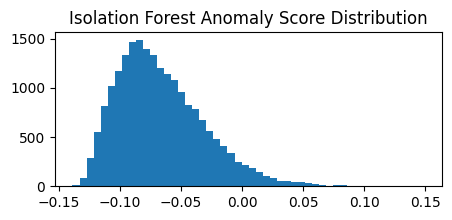

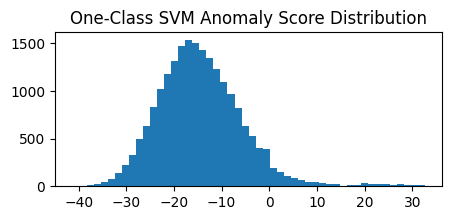

In [12]:
plt.figure(figsize=(5,2))
plt.hist(iso_scores, bins=50)
plt.title("Isolation Forest Anomaly Score Distribution")
plt.show()

plt.figure(figsize=(5,2))
plt.hist(svm_scores, bins=50)
plt.title("One-Class SVM Anomaly Score Distribution")
plt.show()

In [13]:
if "clinical_phase" in df.columns:
    print(df.groupby("clinical_phase")[["iso_score","svm_score"]].mean())

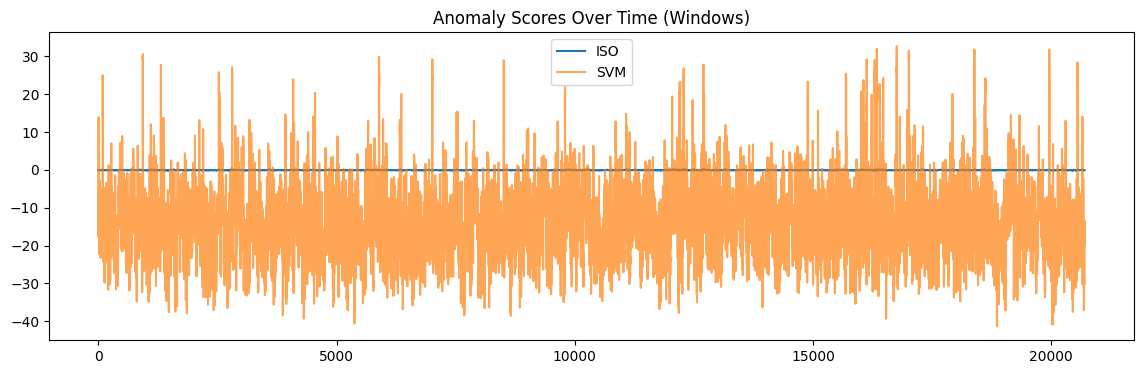

In [14]:
plt.figure(figsize=(14,4))
plt.plot(df["iso_score"], label="ISO")
plt.plot(df["svm_score"], label="SVM", alpha=0.7)
plt.title("Anomaly Scores Over Time (Windows)")
plt.legend()
plt.show()

In [15]:
iso_thresh = np.percentile(iso_scores, 1)   # bottom 1% = anomalies
print("ISO threshold:", iso_thresh)

ISO threshold: -0.12417911035670517


In [16]:
svm_thresh = np.percentile(svm_scores, 1)
print("SVM threshold:", svm_thresh)

SVM threshold: -31.9667175916956


In [17]:
iso_anomaly_flags = (iso_scores < iso_thresh).astype(int)
svm_anomaly_flags = (svm_scores < svm_thresh).astype(int)

In [18]:
combined_flags_and = ((iso_anomaly_flags == 1) & (svm_anomaly_flags == 1)).astype(int)

In [19]:
def extract_events(flags):
    events = []
    in_event = False
    start = None

    for i, f in enumerate(flags):
        if f == 1 and not in_event:
            in_event = True
            start = i
        elif f == 0 and in_event:
            end = i - 1
            events.append((start, end))
            in_event = False

    if in_event:
        events.append((start, len(flags) - 1))

    return events

In [20]:
anomaly_events = extract_events(combined_flags_and)

print("Detected anomaly events:")
for e in anomaly_events:
    print(e)

Detected anomaly events:
(1837, 1837)
(1858, 1859)
(2302, 2302)
(3087, 3087)
(3944, 3945)
(3947, 3947)
(4313, 4313)
(4929, 4929)
(5591, 5591)
(7606, 7608)
(7681, 7682)
(9502, 9502)
(9704, 9704)
(12255, 12255)
(12561, 12561)
(13937, 13937)
(14284, 14284)
(14677, 14677)
(15776, 15776)
(15814, 15814)
(15868, 15868)
(18861, 18861)
(19035, 19036)
(19683, 19683)
(19864, 19864)
(19868, 19869)
(20025, 20025)
(20044, 20044)


In [21]:
df = pd.read_csv("/content/window_dataset.csv")

In [23]:
df.columns

Index(['hr_mean', 'spo2_mean', 'sbp_mean', 'dbp_mean', 'hr_std', 'spo2_std',
       'sbp_std', 'dbp_std', 'hr_slope', 'spo2_slope', 'sbp_slope',
       'dbp_slope', 'hr_min', 'hr_max', 'spo2_min', 'spo2_max', 'hr_spo2_corr',
       'pp_mean', 'pp_std', 'motion_mean', 'motion_max', 'patient_id'],
      dtype='object')

In [24]:
time_index = np.arange(len(df))

In [29]:
hr_window = df["hr_mean"]

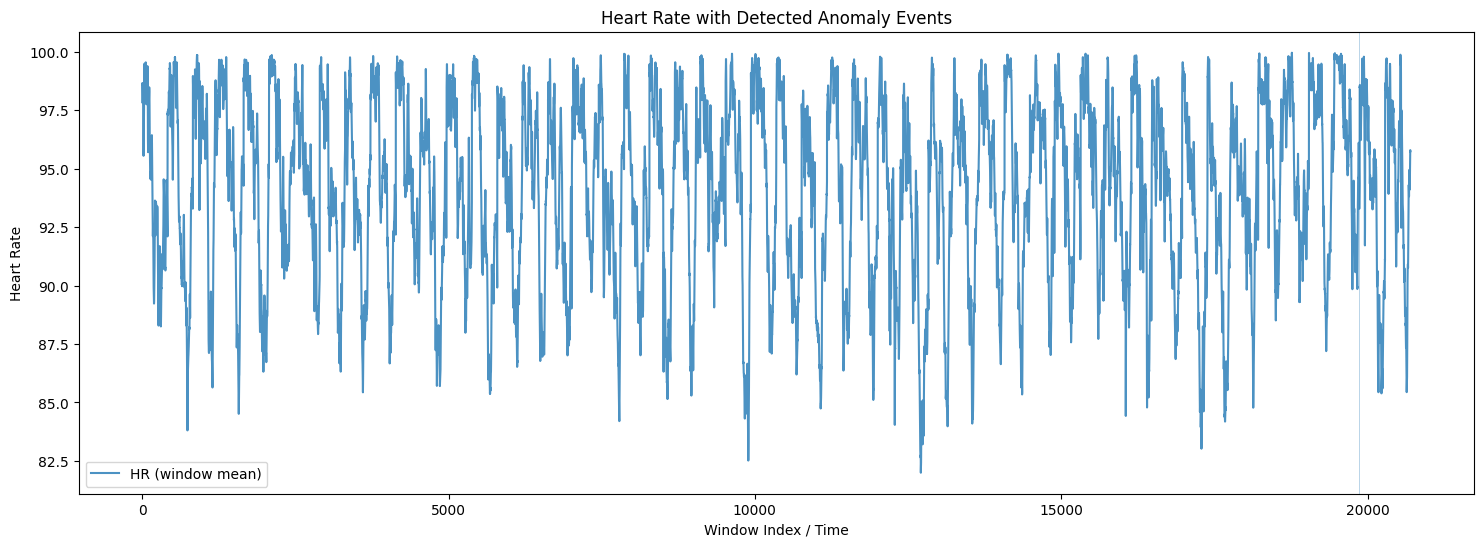

In [30]:
plt.figure(figsize=(18,6))

# Plot main signal
plt.plot(time_index, hr_window, label="HR (window mean)", alpha=0.8)

# Overlay anomaly regions
for (start, end) in anomaly_events:   # or anomaly_events
    plt.axvspan(time_index[start],
                time_index[end],
                alpha=0.3)

plt.title("Heart Rate with Detected Anomaly Events")
plt.xlabel("Window Index / Time")
plt.ylabel("Heart Rate")
plt.legend()
plt.show()

In [32]:
 print("ISO flags:", np.sum(iso_anomaly_flags))
print("SVM flags:", np.sum(svm_anomaly_flags))
print("Combined flags:", np.sum(combined_flags_and))

ISO flags: 207
SVM flags: 207
Combined flags: 35


In [33]:
print("ISO score min/max:", iso_scores.min(), iso_scores.max())
print("SVM score min/max:", svm_scores.min(), svm_scores.max())

ISO score min/max: -0.13877938643776838 0.14951142186089128
SVM score min/max: -41.295122829707296 32.613201354791


In [34]:
print("ISO threshold:", iso_thresh)
print("SVM threshold:", svm_thresh)

ISO threshold: -0.12417911035670517
SVM threshold: -31.9667175916956


In [35]:
iso_thresh_debug = np.percentile(iso_scores, 99)
debug_flags = iso_scores > iso_thresh_debug

print("Debug flags:", np.sum(debug_flags))

Debug flags: 207


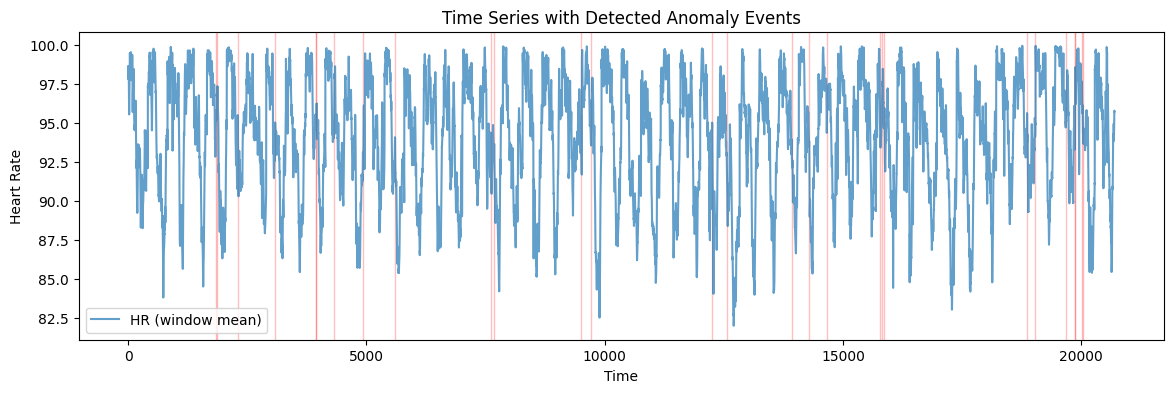

In [39]:
plt.figure(figsize=(14,4))

plt.plot(time_index, hr_window, label="HR (window mean)", alpha=0.7)

# Overlay anomaly windows
for (start, end) in anomaly_events:
    plt.axvspan(time_index[start], time_index[end],
                color='red', alpha=0.25)

plt.title("Time Series with Detected Anomaly Events")
plt.xlabel("Time")
plt.ylabel("Heart Rate")
plt.legend()
plt.show()

In [40]:
scaler, iso = joblib.load("iso_forest.pkl")
ocsvm = joblib.load("ocsvm.pkl")


In [41]:
from google.colab import files
uploaded=files.upload()

Saving patient_001_artifacts.csv to patient_001_artifacts.csv


In [42]:
window_df = pd.read_csv("window_dataset.csv")
artifact_df = pd.read_csv("patient_001_artifacts.csv")


In [43]:
FEATURE_COLS = [
    "hr_mean","spo2_mean","sbp_mean","dbp_mean",
    "hr_std","spo2_std","sbp_std","dbp_std",
    "hr_slope","spo2_slope","sbp_slope","dbp_slope",
    "hr_min","hr_max","spo2_min","spo2_max",
    "hr_spo2_corr","pp_mean","pp_std",
    "motion_mean","motion_max"
]

X = window_df[FEATURE_COLS].values
X_scaled = scaler.transform(X)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [44]:
iso_scores = -iso.decision_function(X_scaled)
svm_scores = -ocsvm.decision_function(X_scaled)

In [45]:
ISO_PCTL = 95
SVM_PCTL = 95

iso_thresh = np.percentile(iso_scores, ISO_PCTL)
svm_thresh = np.percentile(svm_scores, SVM_PCTL)

iso_flags = iso_scores > iso_thresh
svm_flags = svm_scores > svm_thresh

combined_flags = iso_flags & svm_flags

print("ISO flags:", iso_flags.sum())
print("SVM flags:", svm_flags.sum())
print("Combined flags:", combined_flags.sum())
print("ISO threshold:", iso_thresh)
print("SVM threshold:", svm_thresh)

ISO flags: 1035
SVM flags: 1035
Combined flags: 673
ISO threshold: -0.00030283128557450826
SVM threshold: 3.0474314692338665e-05


In [46]:
WINDOW_SEC = 30
STEP_SEC   = 5
FS = 1  # 1Hz raw data

def flags_to_intervals(flags):
    intervals = []
    in_event = False
    start = None

    for i, f in enumerate(flags):
        if f and not in_event:
            in_event = True
            start = i
        elif not f and in_event:
            end = i
            intervals.append((start, end))
            in_event = False

    if in_event:
        intervals.append((start, len(flags)))

    # Convert window index → raw time index
    time_intervals = []
    for ws, we in intervals:
        t_start = ws * STEP_SEC
        t_end   = we * STEP_SEC + WINDOW_SEC
        time_intervals.append((t_start, t_end))

    return time_intervals

In [47]:
iso_intervals = flags_to_intervals(iso_flags)
svm_intervals = flags_to_intervals(svm_flags)
combined_intervals = flags_to_intervals(combined_flags)

print("ISO intervals:", len(iso_intervals))
print("SVM intervals:", len(svm_intervals))
print("Combined intervals:", len(combined_intervals))


ISO intervals: 363
SVM intervals: 412
Combined intervals: 262


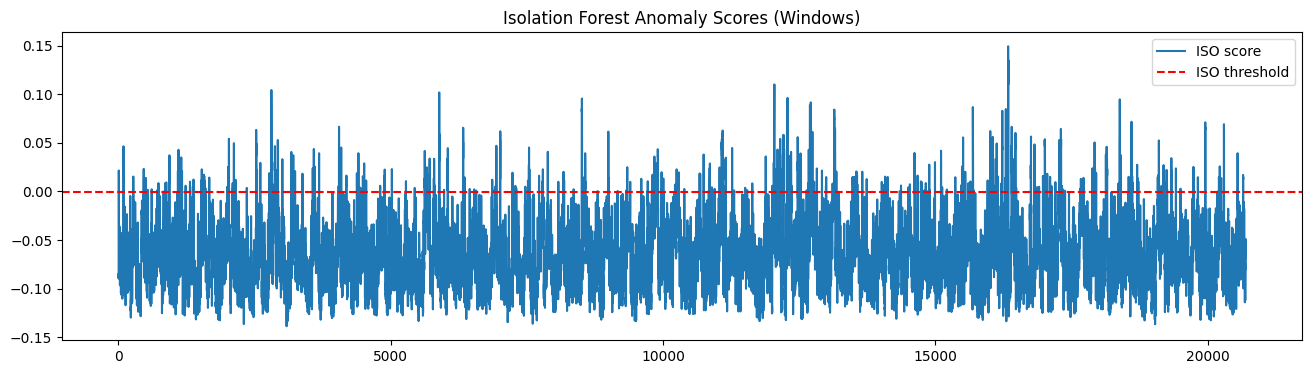

In [49]:
plt.figure(figsize=(16,4))
plt.plot(iso_scores, label="ISO score")
plt.axhline(iso_thresh, color="red", linestyle="--", label="ISO threshold")
plt.title("Isolation Forest Anomaly Scores (Windows)")
plt.legend()
plt.show()


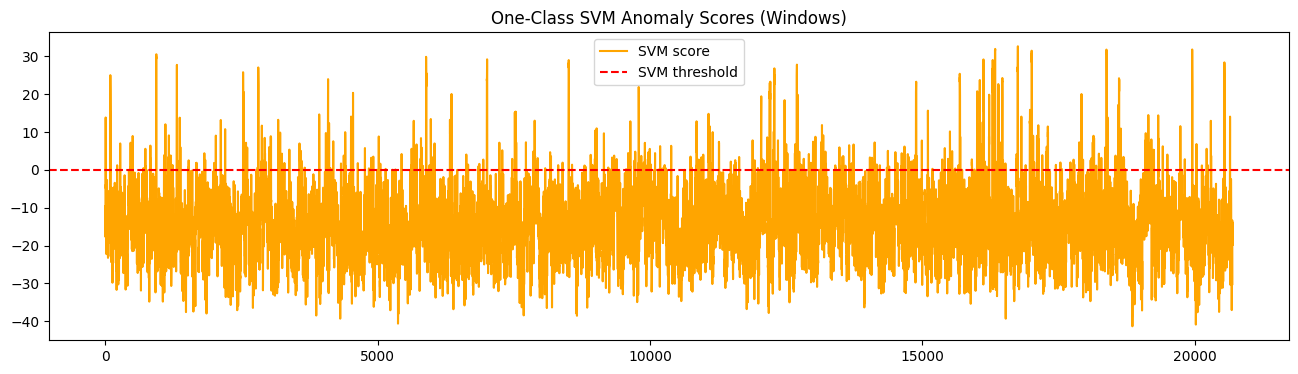

In [50]:
plt.figure(figsize=(16,4))
plt.plot(svm_scores, label="SVM score", color="orange")
plt.axhline(svm_thresh, color="red", linestyle="--", label="SVM threshold")
plt.title("One-Class SVM Anomaly Scores (Windows)")
plt.legend()
plt.show()

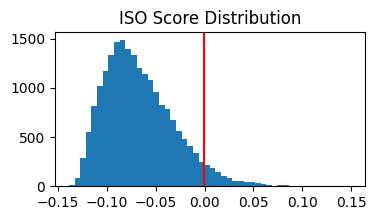

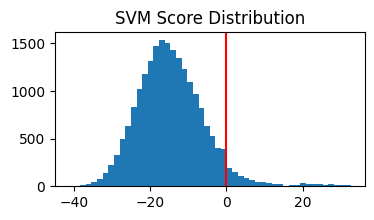

In [55]:
##REPORT
plt.figure(figsize=(4,2))
plt.hist(iso_scores, bins=50)
plt.axvline(iso_thresh, color="red")
plt.title("ISO Score Distribution")
plt.show()

plt.figure(figsize=(4,2))
plt.hist(svm_scores, bins=50)
plt.axvline(svm_thresh, color="red")
plt.title("SVM Score Distribution")
plt.show()

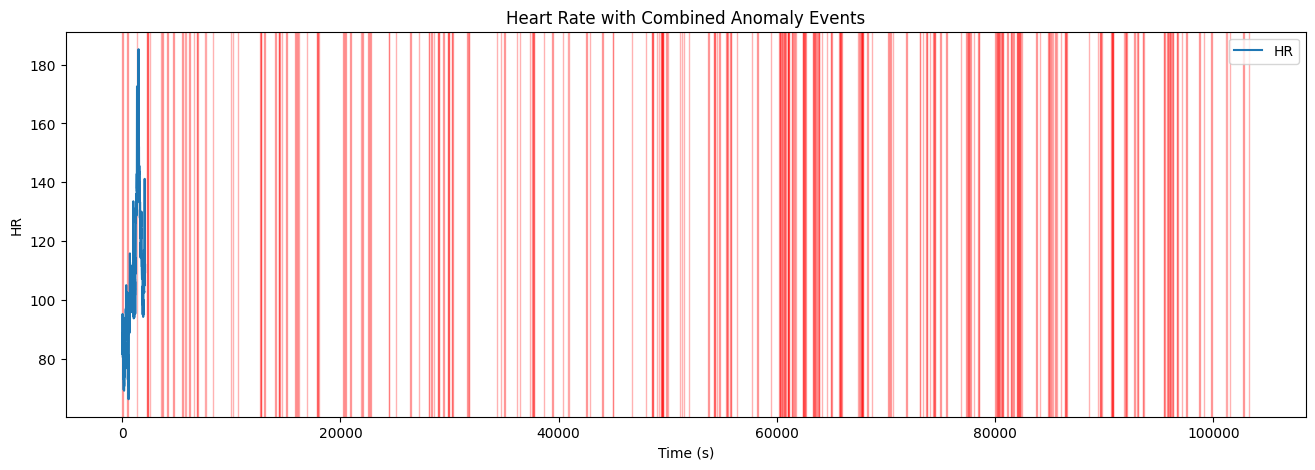

In [52]:
t = artifact_df.index.values
hr = artifact_df["hr"].values

plt.figure(figsize=(16,5))
plt.plot(t, hr, label="HR")

for s, e in combined_intervals:
    plt.axvspan(s, e, color="red", alpha=0.3)

plt.title("Heart Rate with Combined Anomaly Events")
plt.xlabel("Time (s)")
plt.ylabel("HR")
plt.legend()
plt.show()

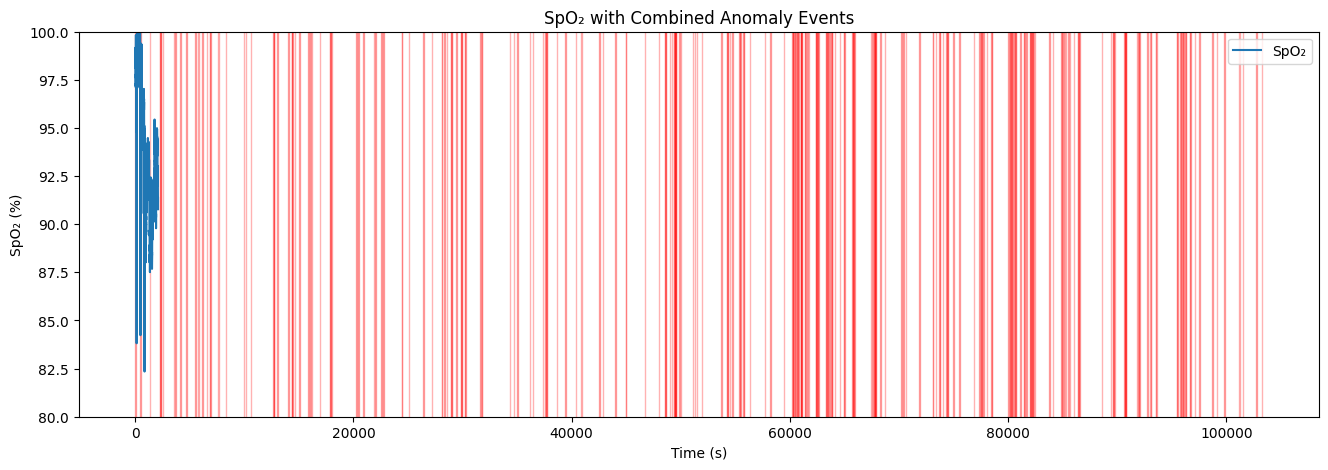

In [53]:
spo2 = artifact_df["spo2"].values

plt.figure(figsize=(16,5))
plt.plot(t, spo2, label="SpO₂")

for s, e in combined_intervals:
    plt.axvspan(s, e, color="red", alpha=0.3)

plt.title("SpO₂ with Combined Anomaly Events")
plt.xlabel("Time (s)")
plt.ylabel("SpO₂ (%)")
plt.legend()
plt.ylim(80,100)
plt.show()

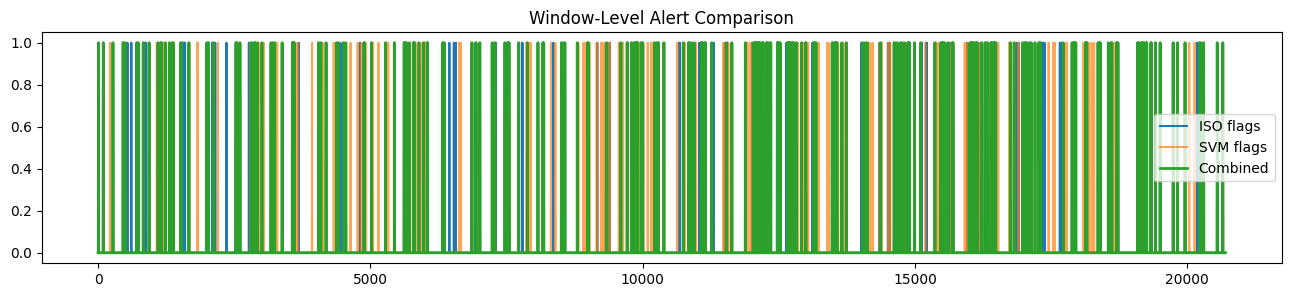

In [54]:
plt.figure(figsize=(16,3))
plt.plot(iso_flags.astype(int), label="ISO flags")
plt.plot(svm_flags.astype(int), label="SVM flags", alpha=0.7)
plt.plot(combined_flags.astype(int), label="Combined", linewidth=2)
plt.title("Window-Level Alert Comparison")
plt.legend()
plt.show()


In [56]:
import numpy as np

def build_event_intervals(flag_array, min_gap=2):
    """
    Convert binary window flags into continuous event intervals.
    min_gap = how many normal windows to allow before splitting event
    """
    intervals = []
    in_event = False
    start = None
    gap = 0

    for i, flag in enumerate(flag_array):
        if flag:
            if not in_event:
                start = i
                in_event = True
                gap = 0
            else:
                gap = 0
        else:
            if in_event:
                gap += 1
                if gap >= min_gap:
                    end = i - gap
                    intervals.append((start, end))
                    in_event = False

    if in_event:
        intervals.append((start, len(flag_array)-1))

    return intervals

# Build intervals
iso_intervals = build_event_intervals(iso_flags)
svm_intervals = build_event_intervals(svm_flags)
combined_intervals = build_event_intervals(combined_flags)

print("ISO events:", len(iso_intervals))
print("SVM events:", len(svm_intervals))
print("Combined events:", len(combined_intervals))

ISO events: 343
SVM events: 393
Combined events: 250


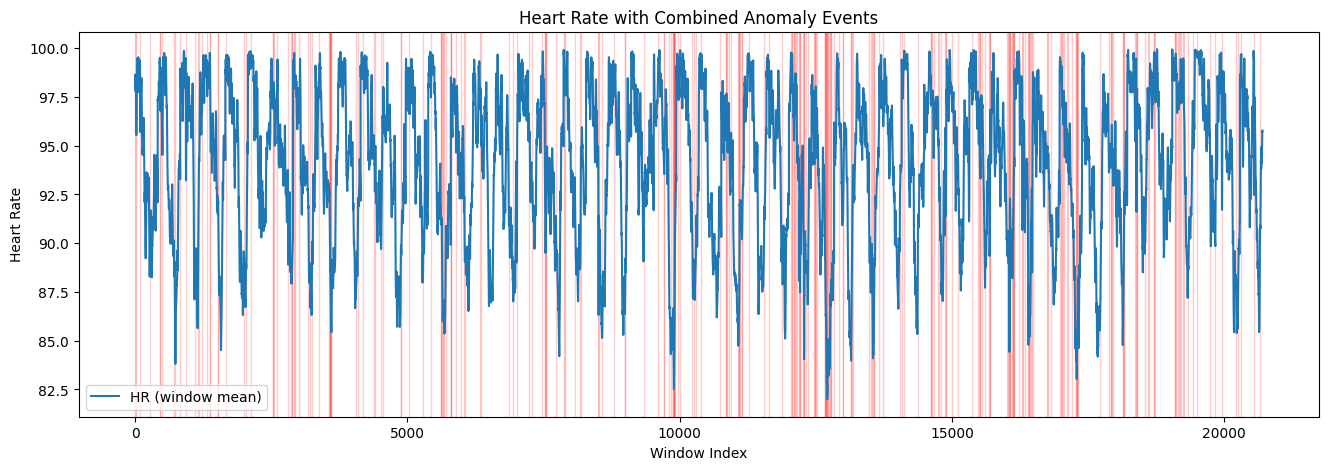

In [59]:
plt.figure(figsize=(16,5))
plt.plot(hr_window, label="HR (window mean)")

for s,e in combined_intervals:
    plt.axvspan(s, e, color="red", alpha=0.2)

plt.title("Heart Rate with Combined Anomaly Events")
plt.xlabel("Window Index")
plt.ylabel("Heart Rate")
plt.legend()
plt.show()


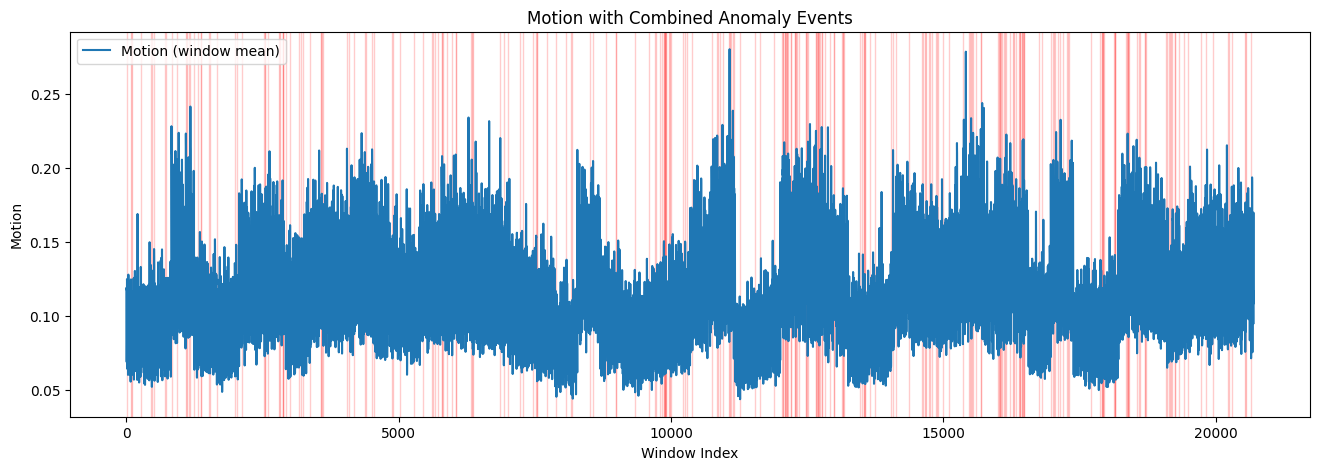

In [61]:
motion_window = df["motion_mean"]
plt.figure(figsize=(16,5))
plt.plot(motion_window, label="Motion (window mean)")

for s,e in combined_intervals:
    plt.axvspan(s, e, color="red", alpha=0.2)

plt.title("Motion with Combined Anomaly Events")
plt.xlabel("Window Index")
plt.ylabel("Motion")
plt.legend()
plt.show()